# User Tutorial on Using the DELPHI Package:

This Jupyter notebook serves as a step-by-step guide for using the DELPHI package. It is intended for users who wish to apply DELPHI to their own datasets, rather than reproduce the plots included in my thesis.

## Important information:

Please replace all instances of `### CHANGE ME ###` with the appropriate paths to your own data.


In [1]:
from DELPHI.LPdetection import LPPreprocess, LPtrain, LPDetect

## 1. Preprocessing Step

This preprocessing step is important. Your images should follow a specific format:  
- Images must be in `.png` format  
- Laser point annotations must be in `.json` format, created using **LabelMe**

If you have annotated using LabelMe, the laser points will be stored automatically under:

<annotation>.json → "shapes" → list of shapes → "points"

### What the Preprocessing Step Does

- Extracts the bounding box of each laser point  
- Computes the center point of the laser point  
- Performs a train-test split, specified by the `train_ratio` (e.g., `0.8` means 80% goes to training)
- Stores the split datasets into the following folders under your data directory:

```
    your_data_folder/
    ├── images/
    ├── annotations/
    ├── train_images/
    ├── train_annotations/
    ├── test_images/
    └── test_annotations/
```

- Creates a dictionary that stores each image and its corresponding annotation, keyed by a unique ID  

This structure enables efficient access to both images and annotations during training.


In [2]:
og_im = "./Your_data_folder/images" ### CHANGE ME ###
og_lp = "./Your_data_folder/annotations" ### CHANGE ME ###
LPPreprocess(impath=og_im, lppath=og_lp, train_ratio=0.8,seed=100) 


Duplicated annotations: []
Found 38 images
Found 98 annotations
Matched pairs: 38
Unmatched images: []
Unmatched annotations: ['0001', '0002', '0003', '0010', '0011', '0020', '0021', '0024', '0026', '0027', '0044', '0052', '0055', '0078', '0081', '0104', '0112', '0121', '0127', '0128', '0133', '0138', '0144', '0154', '0156', '0167', '0172', '0187', '0190', '0196', '0204', '0225', '0232', '0253', '0261', '0268', '0302', '0336', '0358', '0361', '0363', '0383', '0420', '0456', '0480', '0514', '0531', '0584', '0591', '0592', '0602', '0607', '0609', '0662', '0697', '0717', '0790', '0804', '0834', '0857']
Matched 38 pairs → 30 train, 0 validation, 8 test.


In [3]:
impath='./Your_data_folder/train_images' ### CHANGE ME ###
lppath='./Your_data_folder/train_annotations' ### CHANGE ME ###

## 2. Training Step

This training step chooses the number of training images within the 80% training split. This step replicates the methodology from the DELPHI paper, which iterates through different numbers of training images to analyze performance.

In [4]:
train_dict=LPtrain(impath,lppath, num_images = None)

The selected images for this train set are: ['0926', '0333', '0956', '0315', '0455', '0178', '0310', '0734', '1185', '1139', '0828', '1124', '0459', '0148', '1224', '1195', '0188', '0859', '0816', '0231', '0738', '0555', '0470', '0494', '1023', '0282', '1134', '1208', '0700', '0266']


### 2.1 Visualise the data

We can visualise what the image looks like, and where the laser points are by using the `imgdisplay` method:

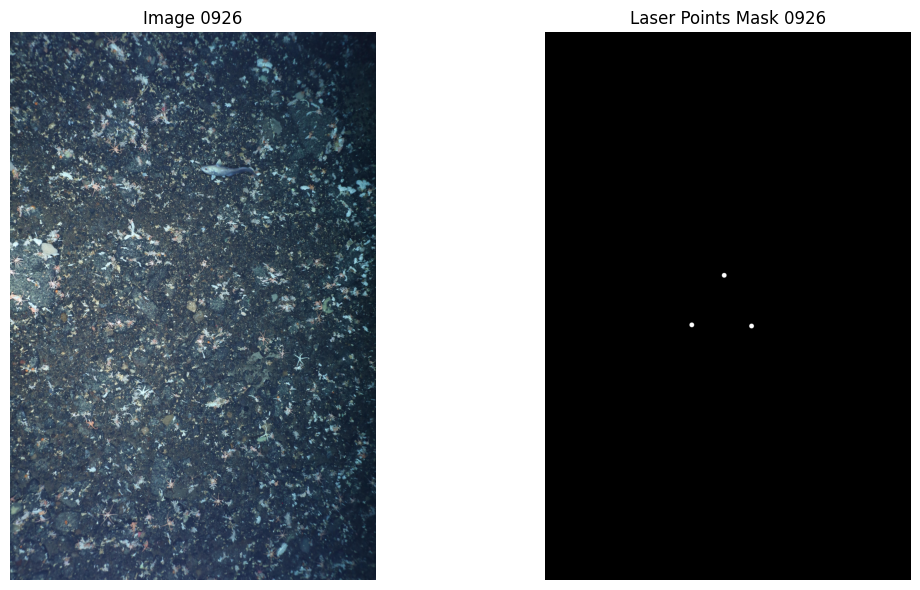

Laser Point Coordinates for Image 0926: [(1880, 2557), (1540, 3078), (2167, 3090)]


In [5]:
LPtrain.imgdisplay(train_dict,"0926") #assumption that the laser points are centered in the image


### 2.2 Spatial Layout Modelling

Use `spatial_learning` method to get the master mask used for detecction later. You can specify the dilation radius using the argument lpradius:

In [6]:
combined_mask = LPtrain.spatial_learning(train_dict,lpradius=25) 

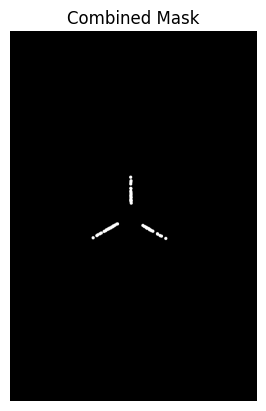

In [7]:
import matplotlib.pyplot as plt

plt.imshow(combined_mask, cmap='gray', vmin=0, vmax=1)
plt.title("Combined Mask")
plt.axis('off')
plt.savefig("./results/figures/4.8.7__t1combined_mask.png", dpi=300)
plt.show()


### 2.3 Colour Feature Learning

Use `color_learning` method to learn the colour threshold (threshold) and curated laser point colours (S_gamma) from the training data, which will be used for detection later:

In [8]:
threshold, cluster_gamma, S_gamma, fig = LPtrain.color_learning(train_dict, lpradius = 3, backgroundradius = 25, plot = True)

## 3. Detection step

This detection step takes the test images and applies the colour and spatial thresholding learnt earlier in the training step.

In [9]:
test_detector = LPDetect(
    impath='./Your_data_folder/test_images', ### CHANGEME ###
    lppath='./Your_data_folder/test_annotations', ### CHANGEME ###
    threshold=threshold,
    cluster_gamma=cluster_gamma,
    S_gamma=S_gamma,
    num_images= None
)

The selected images for this test set are: ['0381', '0942', '1220', '1011', '0458', '1106', '0853', '0590']


### 3.1 Visualise the data:

Similar to the training step, you can visualise the images with the dictionary using the `imgdisplay` method. 

In [ ]:
LPtrain.imgdisplay(test_detector,"0381") #assumption that the laser points are centered in the image

### 3.1 Colour Thresholding

The DELPHI paper specifies that a grey value image should be created in the first step of the detection process. This process assigns a score to every pixel in the test image based on how similar its colour is to the learned laser point (LP) curated colours:

- **High similarity**: Bright pixel value
- **Low similarity**: Dim pixel value  
- **Below threshold**: Set to 0 (black)

This is implemented using the `gray_value_image` method with the following options:
- Set `plot=True` to visualize the result
- Specify a path to save the image at 300 DPI resolution

In [10]:
test_detector.gray_value_image(plot=True,save_path="./results/figures/4.8.5_t1greyimgvalue.png")

100%|██████████| 8/8 [07:52<00:00, 59.01s/it]


[SAVED] Grid plot saved to ./results/figures/4.8.5__t1greyimgvalue.png


### 3.2 Morphological Opening Filter

After creating the grey value image, it is filtered using a morphological opening filter to remove isolated single pixels that are not connected to other pixels. These isolated pixels are likely noise rather than actual laser points. Using the `binary_mask_image` method you can:

- Adjust the kernel dimensions using the `kernel_dim` argument
- Set `plot=True` to visualize the result
- Specify a path to save the image at 300 DPI resolution

In [12]:
test_detector.binary_mask_image(plot=True, morphology = True, kernel_dim= 3, save_path="./results/figures/4.8.4_t1morphology.png")


[0381] Raw binary pixels before morphology: 74259
[0381] Binary pixels after morphology: 51429
[0942] Raw binary pixels before morphology: 258164
[0942] Binary pixels after morphology: 184308
[1220] Raw binary pixels before morphology: 335
[1220] Binary pixels after morphology: 72
[1011] Raw binary pixels before morphology: 232977
[1011] Binary pixels after morphology: 209820
[0458] Raw binary pixels before morphology: 659285
[0458] Binary pixels after morphology: 553528
[1106] Raw binary pixels before morphology: 987055
[1106] Binary pixels after morphology: 660112
[0853] Raw binary pixels before morphology: 712134
[0853] Binary pixels after morphology: 517442
[0590] Raw binary pixels before morphology: 154814
[0590] Binary pixels after morphology: 126183
[SAVED] Grid plot saved to ./results/figures/4.8.4_t1morphology.png


### 3.3 Apply Spatial Layout Modeling Master Mask

After removing noise, apply the learned mask from the training step to limit potential laser points to specific regions on the test image. This spatial constraint helps focus detection on areas where laser points are most likely to occur. Use the `apply_train_mask` method with the master mask variable saved from the training step.

**Parameters:**
- `master_mask`: The learned mask from training (saved in your variable)
- `plot=True`: Visualize the result
- Specify a path to save the image at 300 DPI resolution

In [13]:
test_detector.apply_train_mask(combined_mask,save_path="./results/figures/4.8.3_t1mastermask.png") 

[SAVED] Grid plot saved to ./results/figures/4.8.3_t1mastermask.png


### 3.4 Region Selection

In the grey value image, connected pixels are grouped together and their pixel values are summed. The groups with the top 5 highest scores are selected as candidate regions for laser point prediction. Use the `connect_and_weight_regions` method with the following parameters:

**Parameters:**
- `target_number_of_regions`: Number of regions to consider for future LP selection
- `plot=True`: Visualize the result
- Specify a path to save the image at 300 DPI resolution

In [14]:
test_detector.connect_and_weight_regions(target_number_of_regions=5,plot=True,save_path="./results/figures/4.8.2_t1regionselection.png")


[0381] Connected regions found: 4
[0381] LP candidates found: 4
[0942] Connected regions found: 2
[0942] LP candidates found: 2
[1220] Connected regions found: 1
[1220] LP candidates found: 1
[1011] Connected regions found: 4
[1011] LP candidates found: 4
[0458] Connected regions found: 6
[0458] LP candidates found: 5
[1106] Connected regions found: 39
[1106] LP candidates found: 5
[0853] Connected regions found: 59
[0853] LP candidates found: 5
[0590] Connected regions found: 6
[0590] LP candidates found: 5
[SAVED] Grid plot saved to ./results/figures/4.8.2_t1regionselection.png


### 3.5 Predict Laser Point with Triangulation

After selecting five possible regions of laser points, triangles are formed between every combination of 3 laser points. These triangles are compared to the triangles from the training images to find the best match. The triangle with the closest Euclidean distance is chosen as the predicted laser points. Use the `predict_laserpoint` method with the following parameters:


In [15]:
results = test_detector.predict_laserpoint(train_dict.image_dict)

[Warning] Not enough LP candidates for 0942 — storing raw candidates
[Warning] Not enough LP candidates for 1220 — storing raw candidates


### 3.6 Performance Evaluation

To evaluate performance following the DELPHI paper methodology, recall, precision, and F1-score metrics are calculated. The evaluation identifies which test images successfully predicted all three laser points as true positives. Use the `performance_test` method to return the precision, recall and f1-score, as well as bad_ids. bad_ids is a kist of image IDs that failed to predict all three laser points as true positives.

In [16]:
precision, recall, f1, bad_ids = test_detector.performance_test()

ground truth and predicted points for 0381 is [(1881, 2577), (1575, 3057), (2170, 3089)] and [(2171, 3090), (1882, 2576), (1575, 3057)]
ground truth and predicted points for 0942 is [(1879, 2535), (1491, 3101), (2200, 3111)] and [(1494, 3105), (1879, 2535)]
ground truth and predicted points for 1220 is [(1882, 2634), (1622, 3027), (2102, 3047)] and [(1881, 2633)]
ground truth and predicted points for 1011 is [(1879, 2442), (1408, 3151), (2378, 3212)] and [(2318, 3192), (2287, 3185), (2305, 3184)]
ground truth and predicted points for 0458 is [(1879, 2555), (1521, 3091), (2209, 3115)] and [(2211, 3115), (1518, 3093), (1881, 2555)]
ground truth and predicted points for 1106 is [(1882, 2455), (1444, 3130), (2258, 3138)] and [(1444, 3130), (1882, 2455), (2163, 3112)]
ground truth and predicted points for 0853 is [(2399, 3222), (1325, 3199), (1877, 2286)] and [(1880, 2370), (1861, 2590), (2401, 3222)]
ground truth and predicted points for 0590 is [(1879, 2555), (1545, 3073), (2186, 3098)] a

### 3.7 Visualize Predictions Like the DELPHI Paper

This creates a visualization that replicates Figure 3 from the DELPHI paper, showing the original image with the master mask overlayed translucently and the predicted laser points projected on top. Use the `visualize_overlay` method with the following parameters:

**Parameters:**
- `image`: The original test image
- `combined_mask`: The master mask generated during the training phase
- `predicted_points`: Access from the test dictionary
- `lpradius`: Radius to dilate the laser points for visibility
- `title`: Title for the visualization
- `block_size`: Dilation size for the master mask to match DELPHI paper style
- `save_path`: Path to save the image at 300 DPI resolution

In [17]:
test_dict = test_detector.image_dict
image_0196 = test_dict["0381"]["image"]
predicted_lp_0196 = test_dict["0381"]["predicted_laser_points"]
test_detector.visualize_overlay(image_0196, combined_mask, predicted_lp_0196, lpradius=30, title="0381 results",block_size=60, save_path="./results/figures/4.8.6_t1exampleresult.png")



[SAVED] Overlay visualization saved to ./results/figures/4.8.6_t1exampleresult.png


### 3.8 Visualize Failed Predictions

To visualize all failed predictions, use the `visualise_failed_predictions` method. This takes the `bad_ids` saved from the performance evaluation (images that failed to predict all 3 true positives) and displays these failed cases for analysis. Change the following parameters if needed:

**Parameters:**
- `bad_ids`: List of failed image IDs from performance evaluation
- `lpradius`: Dilation radius for laser points to improve visibility (recommended since predicted points are very small)
- `save_path`: Optional path to save the visualizations

In [18]:
test_detector.visualise_failed_predictions(bad_ids, lpradius= 50,save_path="./results/figures/4.8.1_t1failedpred.png")


These test images failed to predict three laser points (5 total):
['0942', '1220', '1011', '1106', '0853']

